## PythonのAutoFeatを使った自動特徴量エンジニアリング （Automatic Feature Engineering）その2（分類問題）

url: https://www.salesanalytics.co.jp/datascience/datascience028/

    第232話｜3タイプの特徴量エンジニアリング（feature engineering）基礎テクニック

url: https://www.salesanalytics.co.jp/column/no00232/#Wrapper_Method

    数理モデルを作る上で特徴量エンジニアリング（Feature Engineering）は地味に重要です。

    例えば、より精度の高い予測モデルを構築したいのであれば、アルゴリズムのパラメータチューニングとともに特徴量エンジニアリング（Feature Engineering）に注力したほうがいいでしょう。

    Pythonに幾つかの自動特徴量エンジニアリング（Automatic Feature Engineering）のためのパッケージがあります。

    その中の1つに「AutoFeat」というものがあります。回帰問題と分類問題で利用できます。

    前回は、回帰問題に対し「AutoFeat」を自動特徴量エンジニアリング（Automatic Feature Engineering）のお話しをしました。「AutoFeat」のインストール方法などを含め知りたい方は、以下の前回記事を参考にして頂ければと思います。

    url: https://www.salesanalytics.co.jp/datascience/datascience027/

    今回は、AutoFeatを使った「分類問題」での使用方法や手順などを簡単に説明します。

## 数理モデルのアルゴリズム
    AutoFeatの分類問題に対するアルゴリズムは、ロジスティック回帰という分類問題で最もオーソドックスなものです。

    ただ、AutoFeatはclass_weightというパラメータにbalancedと指定しています。分類問題のクラスの数に偏りがある場合に、
    クラスごとの重みを調整するどうかを指定するパラメータでデフォルトは「None」（無調整）です。

    分類問題のクラスとは、例えば受注を予測するモデルの場合、受注と失注がクラスです（受注クラス・失注クラス）。
    どちらかのクラスの数が極端に少ない場合があります。例えば、10,000件中、受注が100件で失注が9,900件の場合です。
    すべて失注と予測すると、正答率は99%になります。永久に受注を予測できないモデルが出来上がります。
    このようなことにならないようクラスごとの重みを調整し、クラスの数に偏りを緩和する必要があります。
    そのやり方の1つが、「class_weight=’balanced’」とすることです。他にもやり方はありますが、本題とは無関係なので割愛します。

    ちなみに、AutoFeatのロジスティック回帰はScikit-Learn（sklearn）のものを使っています。

## データセット
    今回はscikit-learnから提供されている乳がんの診断結果のデータセットを使います。

    目的変数Yは、悪性クラスと良性クラスを表す以下の2値データです。
    悪性（=0）
    良性（=1）

    特徴量は、以下の10変数です。
    radius：細胞核の中心から外周までの距離
    texture：画像のグレースケールの標準偏差
    perimeter：細胞核周囲の長さ
    area：細胞核の面積
    smoothness：細胞核の直径の局所分散値
    compactness：perimeter^2/area – 1.0で計算される値
    concavity：輪郭の凹面度の重大度
    concave point：輪郭の凹面部の数
    symmetry：対称性

## 構築するモデル
    今回は、4つのモデルを構築してみます。

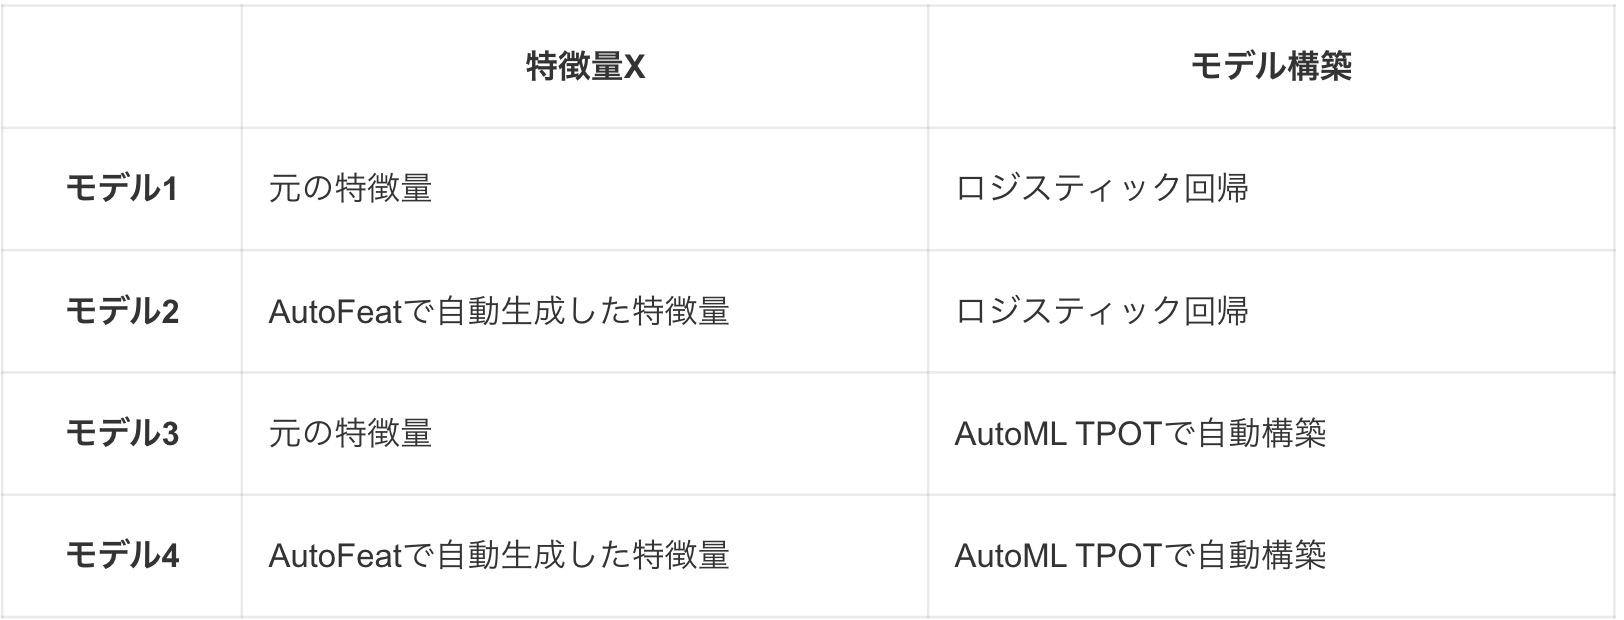

    AutoML（自動機械学習）やTPOTに関しては、以下を参考にして頂ければと思います。
    AutoML（自動機械学習）TPOTは、単により最適な予測モデルを自動構築するだけでなく、パイプライン全体を最適化するので、
    特徴量エンジニアリング（Feature Engineering）を一部自動化しています。

    url: https://www.salesanalytics.co.jp/automl/

## モデル1と2を構築し検証する
    次の2つのモデルを学習データで構築し、構築したモデルをテストデータで精度検証（accuracy：正答率）します。

    モデル1：元の特徴量を使ったロジスティック回帰モデル
    モデル2：AutoFeatで自動生成した特徴量を使ったロジスティック回帰モデル

    先ず、必要なライブラリーを読み込みます。

    以下、コードです。

In [1]:
pip install autofeat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 8.2 MB/s eta 0:00:00


In [2]:
# ライブラリーの読み込み
import pandas as pd
from autofeat import AutoFeatClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

    次に、データセットを読み込みます。

    以下、コードです。

In [3]:
# データセットの読み込み
load_breast_cancer = load_breast_cancer(as_frame=True)
X = load_breast_cancer.data
y = load_breast_cancer.target

In [4]:
display(X)
display(y)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64

    データセットを、学習データとテストデータに分割します。

    以下、コードです。

In [5]:
# データセットの分割（学習データとテストデータ）
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=42)

    学習データ
    特徴量：X_train
    目的変数：y_train
    
    テストデータ
    特徴量：X_test
    目的変数：y_test

    AutoFeatの特徴量エンジニアリングのモデルを定義します。

    以下、コードです。

In [6]:
# モデル定義
model = AutoFeatClassifier(verbose=1)

    今回は分類問題なので「AutoFeatClassifier」です。

    実行経過を表示させるverboseはデフォルトでは「0」（表示しない）ですが、ここでは簡易的な表示をさせるために「1」にしています。
    これらは何も設定しないとデフォルトの状態で実行されます。

    では、自動特徴量エンジニアリング（Automatic Feature Engineering）を実行します。

    以下、コードです。

In [7]:
# 特徴量生成（学習データ利用）
X_train_feature_creation = model.fit_transform(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


[featsel] Scaling data...done.


KeyboardInterrupt: 

    自動生成した特徴量は、X_train_feature_creationに格納しています。確認してみます。

    以下、コードです。

In [ ]:
X_train_feature_creation #確認用

    どのような特徴量が自動生成されたのかが分かると思います。

    一覧で出してみます。

    以下、コードです。

In [ ]:
X_train_feature_creation.columns #生成された特徴量X

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedInc**5', 'HouseAge/AveOccup',
       'log(MedInc)/AveOccup', 'Longitude**3/Latitude',
       'HouseAge**3*Population', 'AveBedrms**2*MedInc**3',
       'MedInc**2*log(AveOccup)', '1/(HouseAge*Population)',
       'log(Population)/AveBedrms', 'sqrt(Population)/AveOccup',
       'sqrt(HouseAge)*Latitude**3', 'sqrt(HouseAge)*log(AveRooms)',
       'Population/MedInc', 'AveRooms/AveBedrms', 'HouseAge*MedInc**3',
       '1/(AveOccup*MedInc)', 'AveOccup/Population', 'sqrt(HouseAge)*MedInc',
       'log(AveBedrms)/MedInc', '1/(AveBedrms*AveOccup)',
       'HouseAge**2/Population', '1/(AveBedrms*Latitude)',
       'Population**2/AveOccup', 'log(AveRooms)/AveRooms',
       'Latitude**3*log(MedInc)', 'HouseAge*log(AveBedrms)',
       'MedInc*sqrt(Population)', 'AveRooms*sqrt(Population)',
       'log(AveOccup)*log(MedInc)', 'sqrt(Population)/HouseAge',
       'sqrt(AveRooms)*Latitu

    数を確認してみます。

    以下、コードです。

In [ ]:
print("number of features in X_train:",  #元の特徴量Xの数
      X_train.shape[1])
print("number of features in X_train_feature_creation:",
      X_train_feature_creation.shape[1]) #新しい特徴量Xの数

# 元の特徴量は30個でしたが、AutoFeatによる特徴量の自動生成で9個の特徴量が新たに追加され、結果的に39個の特徴量になりました。

number of features in X_train: 8
number of features in X_train_feature_creation: 57


    この自動生成した特徴量と同じ特徴量のテストデータを作ります。X_test_feature_creationに格納します。

In [ ]:
# テストデータの特徴量生成
X_test_feature_creation = model.transform(X_test)

    元の特徴量のデータセット（X_trainとy_train）と新たな特徴量のデータセット（X_train_feature_creationとy_train）で、ロジスティック回帰モデルを構築してみます。

    以下、コードです。

In [ ]:
# モデル構築
## model_1
model_1 = LogisticRegression(class_weight='balanced')
model_1.fit(X_train,y_train)

## model_2
model_2 = LogisticRegression(class_weight='balanced')
model_2.fit(X_train_feature_creation, y_train)

    では、テストデータを使いそれぞれのモデルの精度（accuracy：正答率）を比較してみたいと思います。

    以下、コードです。

In [ ]:
# 評価（accuracy, confusion matrix）
print("model_1 accuracy:%.4f" % accuracy_score(y_test,
      model_1.predict(X_test)) )
print(confusion_matrix(y_pred=model_1.predict(X_test),
      y_true=y_test))
print("model_2 accuracy:%.4f" % accuracy_score(y_test,
      model_2.predict(X_test_feature_creation)))
print(confusion_matrix(y_pred=model_2.predict(X_test_feature_creation),
      y_true=y_test))

model_1   R^2: 0.5958
model_2   R^2: 0.6868
LassoLars R^2: 0.6686


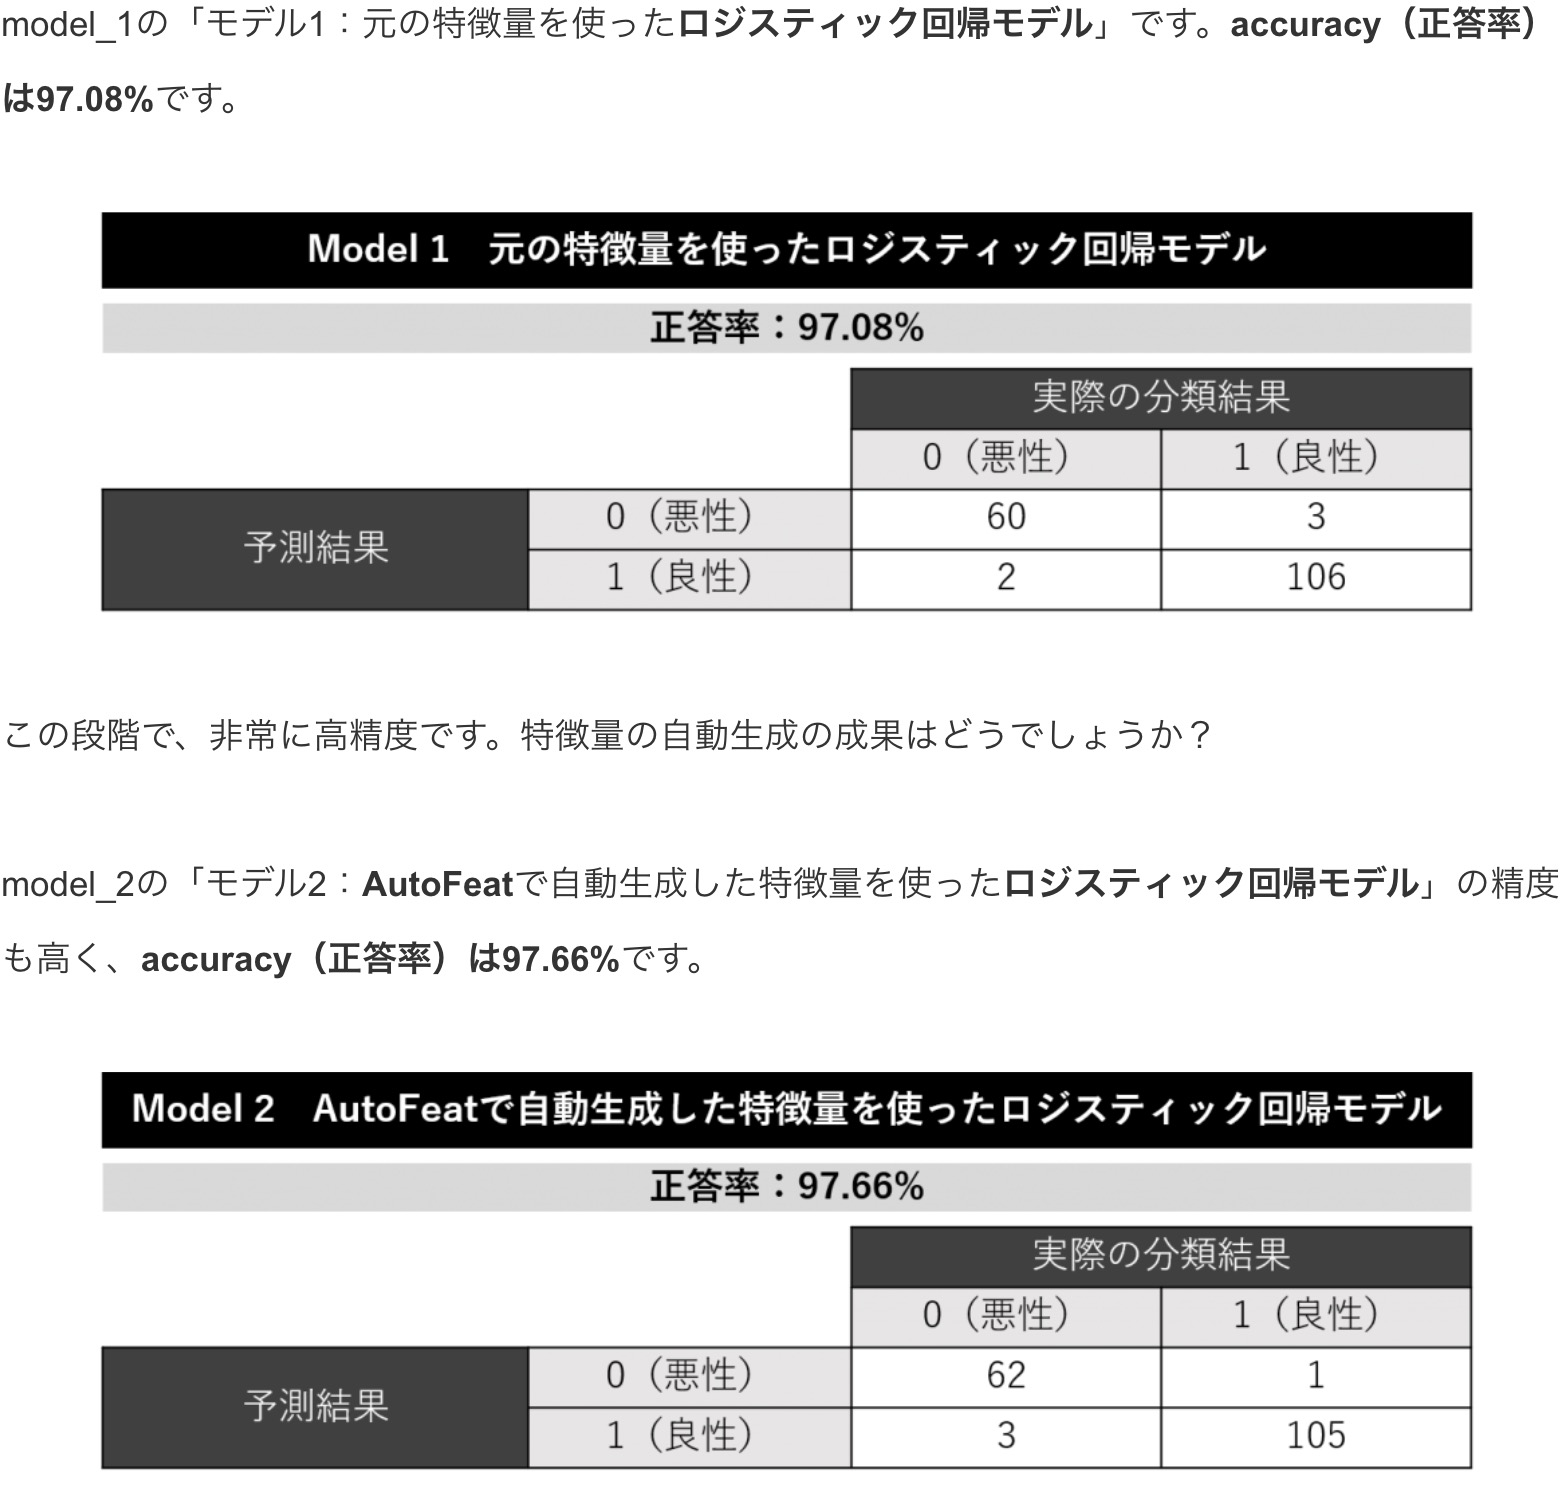

# AutoML（自動機械学習）TPOTでモデル構築（モデル3と4）
    おまけの意味合いが強いですが、次の2つのモデルを学習データで構築し、構築したモデルをテストデータで精度検証（accuracy：正答率）します。

    モデル3：元の特徴量を使いAutoML（自動機械学習）TPOTで自動構築したモデル
    モデル4：AutoFeatで自動生成した特徴量を使ってAutoML（自動機械学習）TPOTで自動構築したモデル
    
    どうなるでしょうか？

    先ず、モデル3です。元の特徴量を使いモデルを自動構築します。

    以下、コードです。



In [ ]:
pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=5b603467bdf12209067355a41e9127ca9d813959ff47e6d7997131499cd668b3
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
# 必要なライブラリの読み込み
from tpot import TPOTClassifier

# POTClassifierの設定
tpot = TPOTClassifier(scoring='accuracy',
                      generations=5,
                      population_size=50,
                      verbosity=2,
                      n_jobs=-1)

# モデル構築
tpot.fit(X_train, y_train)

# 評価（accuracy, confusion matrix）
print("accuracy: %.4f" % accuracy_score(y_test, tpot.predict(X_test)))
print(confusion_matrix(y_pred=tpot.predict(X_test),y_true=y_test))

Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8229240103680615


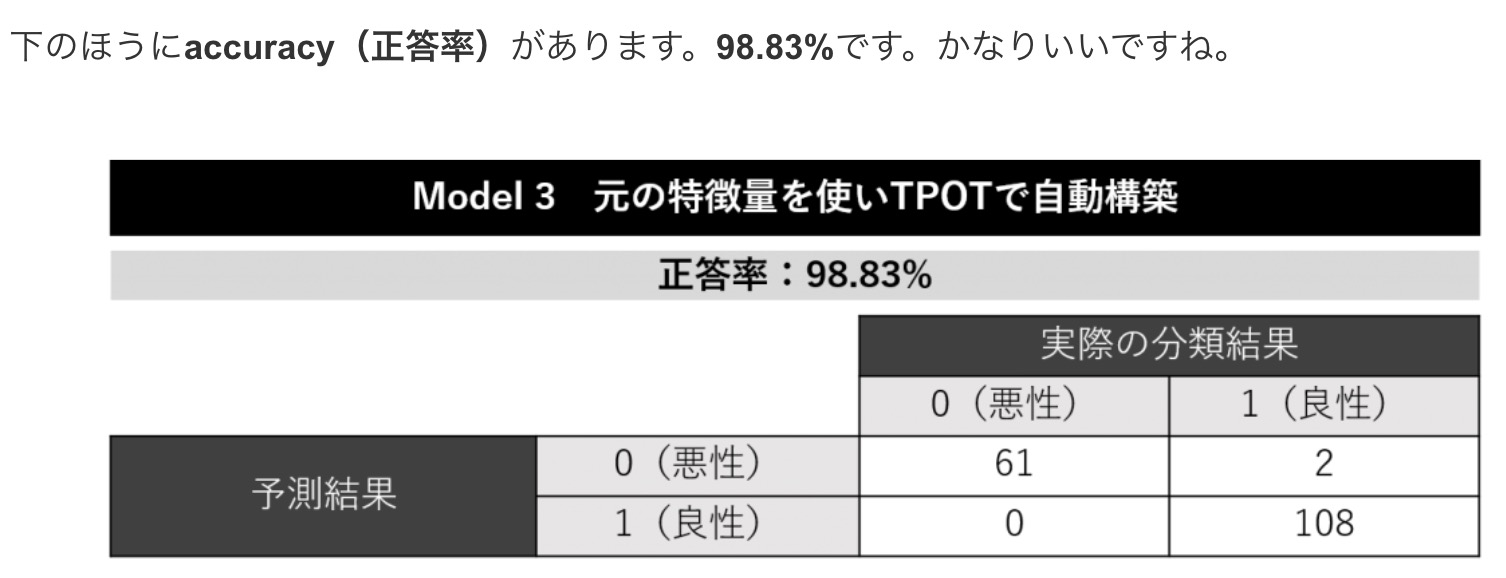

    次に、モデル4です。AutoFeatで自動生成した特徴量を使ってモデルを自動構築します。

    以下、コードです。

In [ ]:
# POTClassifierの設定
tpot2 = TPOTClassifier(scoring='accuracy',
                       generations=5,
                       population_size=50,
                       verbosity=2,
                       n_jobs=-1)

# モデル構築
tpot2.fit(X_train_feature_creation, y_train)

# 評価（accuracy, confusion matrix）
print("accuracy: %.4f" % accuracy_score(y_test, tpot2.predict(X_test_feature_creation)))
print(confusion_matrix(y_pred=tpot2.predict(X_test_feature_creation),y_true=y_test))

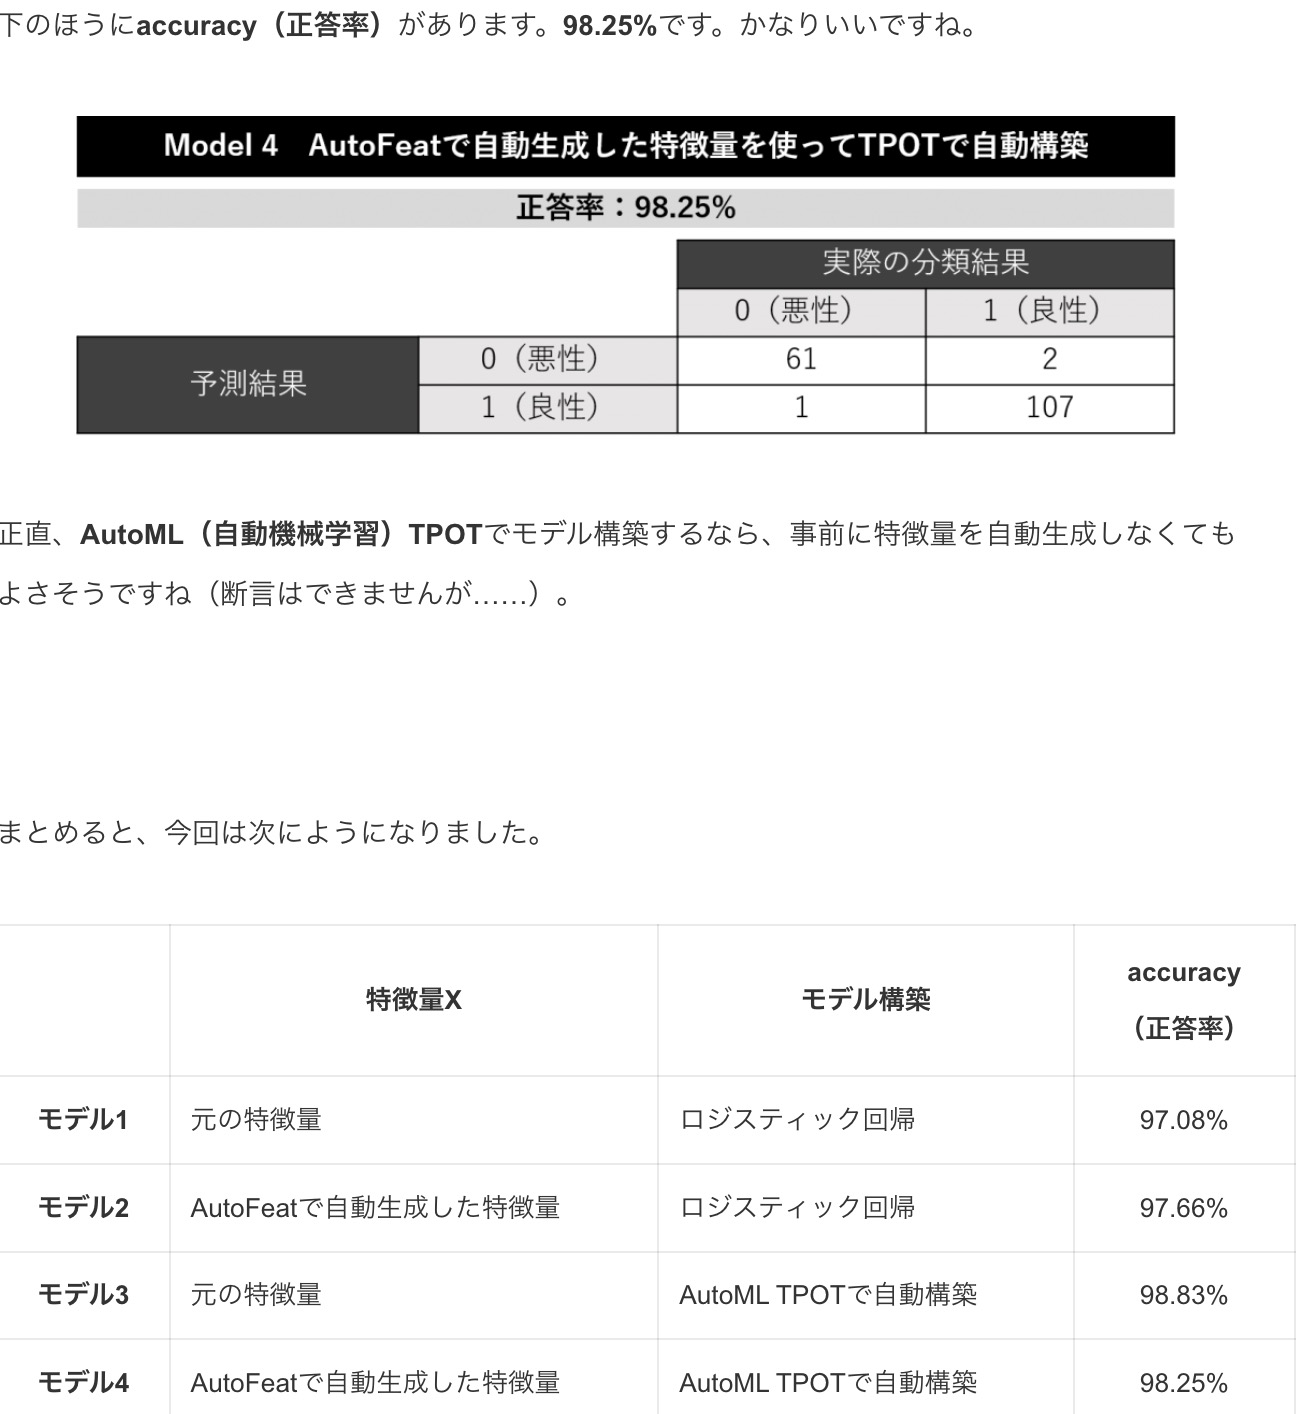

## 次回
    前回は分類問題で、今回は回帰問題でした。

    人によっては、特徴量選択の機能だけ使いたい、という方もいるかもしれません。次回は、特徴量選択の機能だけ使う場合のやり方について、簡単に説明します。